<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-02-01 13:56:59--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-02-01 13:56:59 (175 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


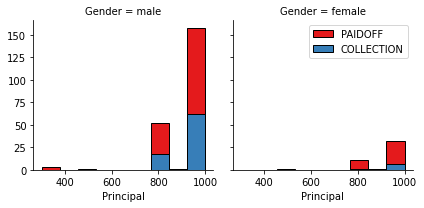

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

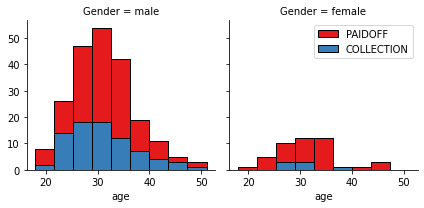

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


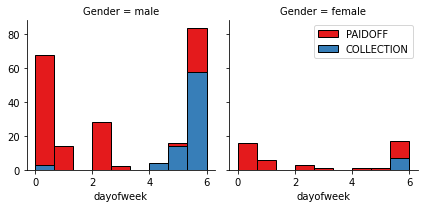

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [16]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [17]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [18]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [19]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [21]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [23]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [27]:
#Step1: Train Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print('Train set:', x_train.shape,y_train.shape)
print('Test set:', x_test.shape,y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [49]:
#Step2: Classification
from sklearn.neighbors import KNeighborsClassifier
#Training
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
#Predict
yhat = neigh.predict(x_test)

#Step3: Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.6857142857142857


K =  7 yields the best accuracy which is  78.57142857142857 %


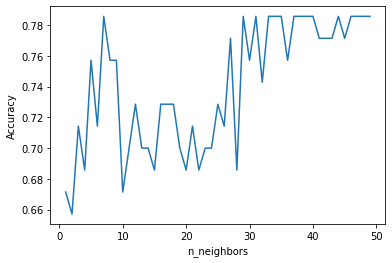

In [53]:
#Create a list to store the accuracies of all the KNN model
Kmax=50
accuracies=[]

for i in range(1,Kmax,1):
  knn=KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
  y_predict = knn.predict(x_test)
  acc = metrics.accuracy_score(y_test,y_predict)
  accuracies.append(acc)
accuracies = np.array(accuracies)
plt.plot(range(1,Kmax,1), accuracies)
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
print('K = ', accuracies.argmax()+1, 'yields the best accuracy which is ', accuracies.max() * 100, '%')
plt.show()

# Decision Tree


In [58]:
# Since the data has already been split into train and test sets, hence there is no need to split it again

#Create the baseline model
from sklearn.tree import DecisionTreeClassifier
decision_tree =  DecisionTreeClassifier().fit(x_train,y_train) # all the default hyperparameters will be used
# Show decision tree summary with the hyperparameters
print('Summary of Baseline', decision_tree)
# Make predictions and print them
train_pred = decision_tree.predict(x_train) # get predicitions on train set
y_pred = decision_tree.predict(x_test) # get predictions on test set (validation set)

# Calculate accuracies on training and testing sets
train_acc = metrics.accuracy_score(y_train,train_pred)
test_acc = metrics.accuracy_score(y_test,y_pred)

print('Accuracy of Baseline Decision Tree Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline Decision Tree Model on Training Set : ', test_acc * 100, '%')

Summary of Baseline DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy of Baseline Decision Tree Model on Training Set :  90.94202898550725 %
Accuracy of Baseline Decision Tree Model on Training Set :  70.0 %


Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')
['PAIDOFF', 'COLLECTION']


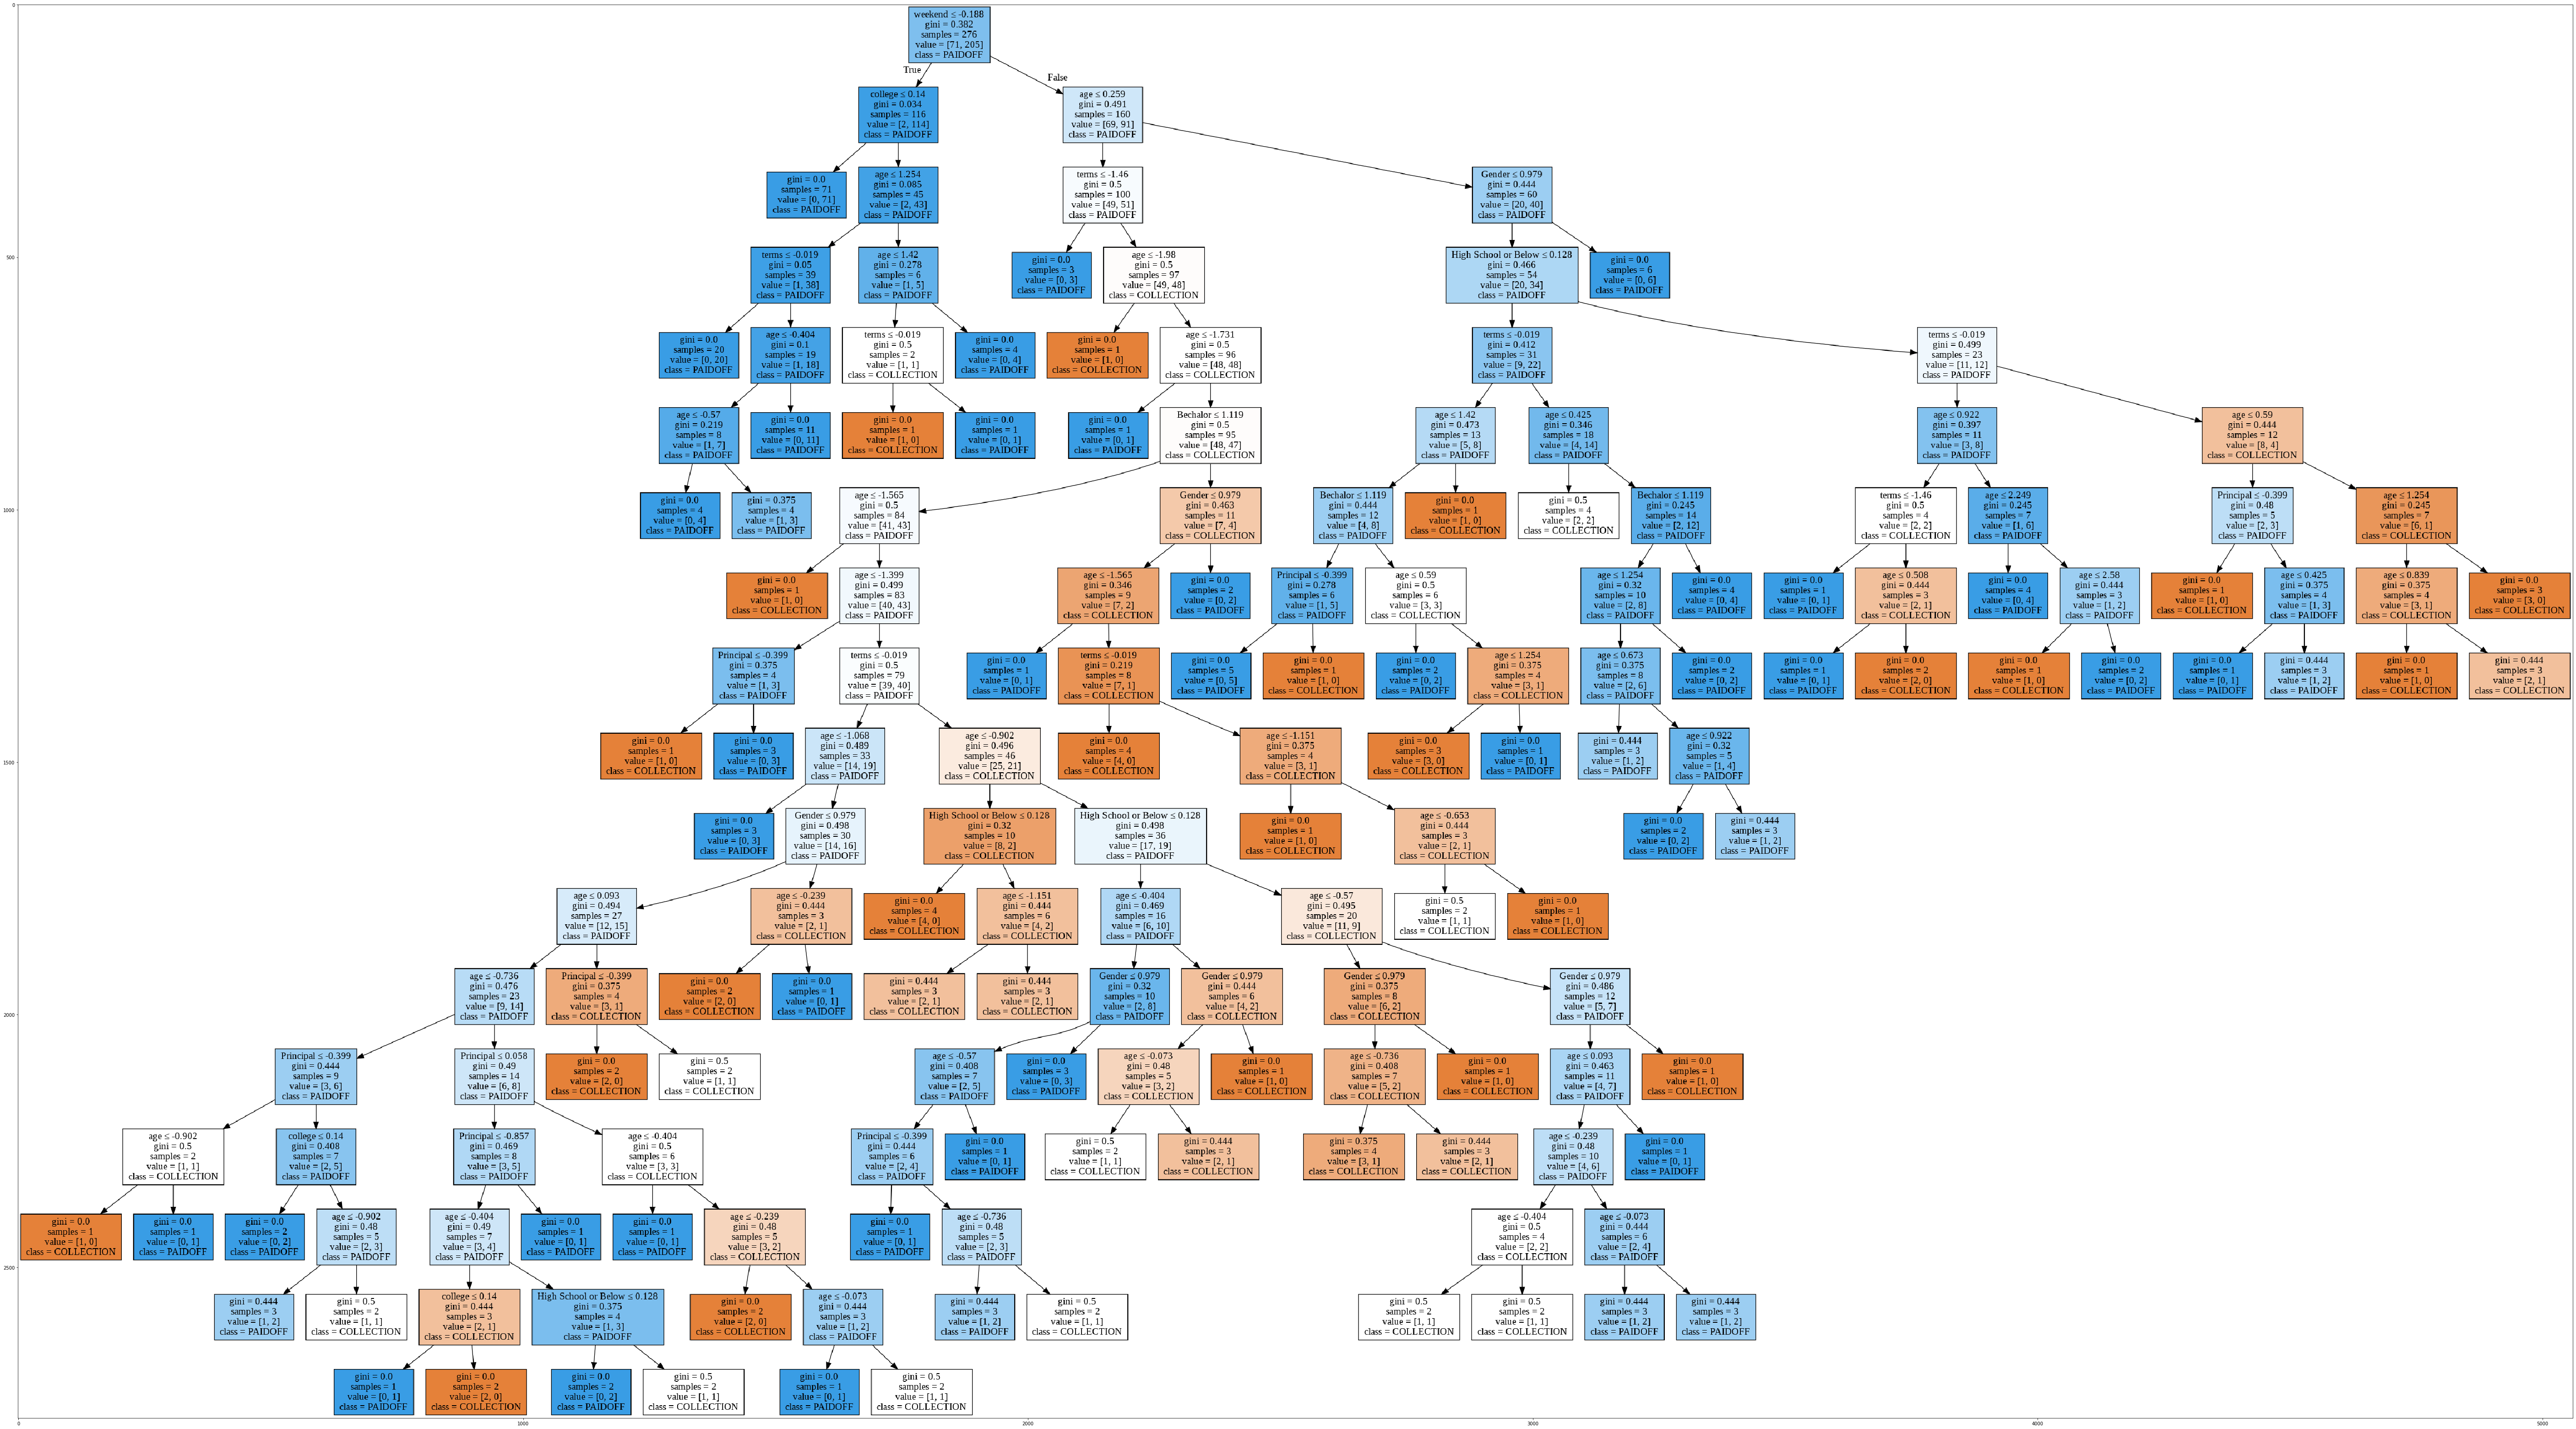

In [63]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline
dot_data = StringIO()
filename = "Paid.png"
featureNames = Feature.columns[0:8]
print(featureNames)
targetNames = df["loan_status"].unique().tolist()
print(targetNames)
out=tree.export_graphviz(decision_tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [68]:
# Create a list of hyperparameters with different values
from sklearn.model_selection import GridSearchCV
params = {'criterion' : ['gini','entropy'],
          'max_features': [i for i in range(1,7)],
          'max_depth' : [8,16,32,64,128,256,512,1024],
          'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
          'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True)}
decision_tree = DecisionTreeClassifier()        
decision_tree_grid = GridSearchCV(decision_tree,param_grid=params) # hyperparameter tuning model         
decision_tree_model = decision_tree_grid.fit(x_train,y_train)
print('Parameter sets were : \n',decision_tree_model.param_grid)
print('\n\n\n\n')
print('Best Hyper Parameters :\n',decision_tree_model.best_params_)

train_pred = decision_tree_grid.predict(x_train) # get predicitions on train set
y_pred = decision_tree_grid.predict(x_test) # get predictions on test set (validation set)

print('\n\n Predictions of Decision Tree Model with Best Parameters on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = metrics.accuracy_score(y_train,train_pred)
test_acc = metrics.accuracy_score(y_test,y_pred)

print('Accuracy of Decision Tree Model with Best Parameters on Training Set : ', train_acc * 100, '%')
print('Accuracy of Decision Tree Model with Best Parameters on Training Set : ', test_acc * 100, '%')

Parameter sets were : 
 {'criterion': ['gini', 'entropy'], 'max_features': [1, 2, 3, 4, 5, 6], 'max_depth': [8, 16, 32, 64, 128, 256, 512, 1024], 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5])}





Best Hyper Parameters :
 {'criterion': 'entropy', 'max_depth': 128, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}


 Predictions of Decision Tree Model with Best Parameters on Testing Set : 

 ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 

# Support Vector Machine


In [75]:
from sklearn.svm import SVC
# Since the data has already been split into train and test sets, hence there is no need to split it again

# Create the baseline model
svm=  SVC().fit(x_train,y_train) # all the default hyperparameters will be used

# Show decision tree summary with the hyperparameters
print('Summary of Baseline', svm)

# Make predictions and print them
train_pred = svm.predict(x_train) # get predicitions on train set
y_pred = svm.predict(x_test) # get predictions on test set (validation set)

# Calculate accuracies on training and testing sets
train_acc = metrics.accuracy_score(y_train,train_pred)
test_acc = metrics.accuracy_score(y_test,y_pred)

print('Accuracy of Baseline SVM Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline SVM Model on Training Set : ', test_acc * 100, '%')

Summary of Baseline SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy of Baseline SVM Model on Training Set :  78.26086956521739 %
Accuracy of Baseline SVM Model on Training Set :  74.28571428571429 %


In [77]:
# Create a list of hyperparameters with different values
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'gamma' : [0.001, 0.01, 0.1, 1],
          'kernel': ['linear','rbf']}

svm= SVC()        
svm_grid = GridSearchCV(svm,param_grid=params) # hyperparameter tuning model
svm_model = svm_grid.fit(x_train,y_train)

print('Parameter sets were : \n',svm_model.param_grid)
print('\n')
print('Best Hyper Parameters :\n',svm_model.best_params_)

train_pred = svm_grid.predict(x_train) # get predicitions on train set
y_pred = svm_grid.predict(x_test) # get predictions on test set (validation set)

# Calculate accuracies on training and testing sets
train_acc = metrics.accuracy_score(y_train,train_pred)
test_acc = metrics.accuracy_score(y_test,y_pred)

print('Accuracy of SVM Model with Best Parameters on Training Set : ', train_acc * 100, '%')
print('Accuracy of SVM Model with Best Parameters on Training Set : ', test_acc * 100, '%')

Parameter sets were : 
 {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}


Best Hyper Parameters :
 {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
Accuracy of SVM Model with Best Parameters on Training Set :  74.27536231884058 %
Accuracy of SVM Model with Best Parameters on Training Set :  78.57142857142857 %


# Logistic Regression


In [71]:
from sklearn.linear_model import LogisticRegression
# Since the data has already been split into train and test sets, hence there is no need to split it again

# Create the baseline model
log_reg =  LogisticRegression().fit(x_train,y_train) # all the default hyperparameters will be used
# Show decision tree summary with the hyperparameters
print('Summary of Baseline', log_reg)
# Make predictions and print them
train_pred = log_reg.predict(x_train) # get predicitions on train set
y_pred = log_reg.predict(x_test) # get predictions on test set (validation set)

# Calculate accuracies on training and testing sets
train_acc = metrics.accuracy_score(y_train,train_pred)
test_acc = metrics.accuracy_score(y_test,y_pred)
print('Accuracy of Baseline Logistic Regression Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline Logistic Regression Model on Validation Set : ', test_acc * 100, '%')


Summary of Baseline LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy of Baseline Logistic Regression Model on Training Set :  77.17391304347827 %
Accuracy of Baseline Logistic Regression Model on Validation Set :  72.85714285714285 %


In [73]:
# Create a list of hyperparameters with different values
params = {'C': [0.001,0.01,0.1,1,10,100],
          'penalty' : ['l1','l2']}
log_reg_clf = LogisticRegression()        
log_reg_grid = GridSearchCV(log_reg,param_grid=params) # hyperparameter tuning model
log_reg_model = log_reg_grid.fit(x_train,y_train)

print('Parameter sets were : \n',log_reg_model.param_grid)
print('\n')
print('Best Hyper Parameters :\n',log_reg_model.best_params_)

train_pred = log_reg_grid.predict(x_train) # get predicitions on train set
y_pred = log_reg_grid.predict(x_test) # get predictions on test set (validation set)

# Calculate accuracies on training and testing sets
train_acc = metrics.accuracy_score(y_train,train_pred)
test_acc = metrics.accuracy_score(y_test,y_pred)

print('Accuracy of Logistic Regression Model with Best Parameters on Training Set : ', train_acc * 100, '%')
print('Accuracy of Logistic Regression Model with Best Parameters on Training Set : ', test_acc * 100, '%')

Parameter sets were : 
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}


Best Hyper Parameters :
 {'C': 0.001, 'penalty': 'l2'}
Accuracy of Logistic Regression Model with Best Parameters on Training Set :  74.27536231884058 %
Accuracy of Logistic Regression Model with Best Parameters on Training Set :  78.57142857142857 %


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

# Model Evaluation using Test set


In [78]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [79]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-02-01 15:28:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-02-01 15:28:26 (634 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [80]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [82]:
#Preprocessing the test set

# Convert the effective_date and due_date columns to a datetime object
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])

# Drop the Unnamed: 0 and Unnamed: 1 columns using indexing
test_df = test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],axis = 1)
test_df.head()

# One Hot Code the Gender column
test_df['Gender'][test_df['Gender'] == 'male'] = 1
test_df['Gender'][test_df['Gender'] == 'female'] = 0

# Create a "dayofweek" column in test_df
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend']=test_df['dayofweek'].apply(lambda x:1 if(x>3) else 0)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [83]:
test_x = Feature_test
test_target=pd.get_dummies(test_df['loan_status'])
test_target.drop(['COLLECTION'], axis =1, inplace= True)

test_y=test_target

test_x = preprocessing.StandardScaler().fit(test_x).transform(test_x)
test_x[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865, -1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288,  0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596, -1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057,  0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942,  0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [87]:
from sklearn.metrics import accuracy_score, classification_report,jaccard_similarity_score
#Evaluation on Test Set
knn_test_pred = knn.predict(test_x)
knn_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in knn_test_pred] # One Hot Code knn_test_pred to get integers for jaccard similarity score and f1 score
knn_jaccard = jaccard_similarity_score(test_y, knn_test_pred)
knn_f1 = f1_score(test_y, knn_test_pred)

# Evaluate on Decision Tree Classifier
decision_tree_pred = decision_tree_grid.predict(test_x)
decision_tree_pred = [1 if x == 'PAIDOFF'  else 0 for x in decision_tree_pred] # One Hot Code decision_tree_pred to get integers for jaccard similarity score and f1 score
decision_tree_jaccard = jaccard_similarity_score(test_y, decision_tree_pred)
decision_tree_f1 = f1_score(test_y, decision_tree_pred)

# Evaluate on SVM Classifier
svm_test_pred = svm_grid.predict(test_x)
svm_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in svm_test_pred] # One Hot Code svm_test_pred to get integers for jaccard similarity score and f1 score
svm_jaccard = jaccard_similarity_score(test_y, svm_test_pred)
svm_f1 = f1_score(test_y, svm_test_pred)
svm_logloss = log_loss(test_y, svm_test_pred)

# Evaluate on Logisitic Regression
log_reg_test_pred = log_reg_grid.predict(test_x)
log_reg_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in log_reg_test_pred] # One Hot Code log_reg_test_pred to get integers for jaccard similarity score and f1 score
log_reg_jaccard = jaccard_similarity_score(test_y, log_reg_test_pred)
log_reg_f1 = f1_score(test_y, log_reg_test_pred)
log_reg_logloss = log_loss(test_y, log_reg_test_pred)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/me

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [88]:
col_names =  ['Algorithm','Jaccard Similarity Score', 'F1 Score','Log Loss']
Report_df = pd.DataFrame(columns = col_names)
Report_df.loc[len(Report_df)] = ['KNN', knn_jaccard,knn_f1, 'NA']
Report_df.loc[len(Report_df)] = ['Decision Tree', decision_tree_jaccard,decision_tree_f1, 'NA']
Report_df.loc[len(Report_df)] = ['SVM', svm_jaccard,svm_f1, svm_logloss]
Report_df.loc[len(Report_df)] = ['Logistic Regression', log_reg_jaccard,log_reg_f1, log_reg_logloss]
Report_df.style.hide_index()

Algorithm,Jaccard Similarity Score,F1 Score,Log Loss
KNN,0.777778,0.869565,NA
Decision Tree,0.796296,0.873563,NA
SVM,0.740741,0.851064,8.954705
Logistic Regression,0.740741,0.851064,8.954705


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
